# 3_Model Evaluation

In this notebook, we evaluate the performance of one or more binary classification models on a test dataset, with a special focus on confusion matrix analysis and threshold optimization for imbalanced data. We will calculate standard evaluation metrics and then improve the analysis by adjusting classification thresholds to reduce false positives while maintaining good recall. The key steps include:

* Baseline Evaluation (Threshold = 0.5): Compute the confusion matrix and metrics such as accuracy, precision, recall, F1-score, and ROC-AUC for each model using the default 0.5 threshold.

* Threshold Optimization: For each model, find the optimal probability threshold that maximizes the F1-score (balance of precision and recall). This helps address class imbalance by potentially improving recall or precision as needed.
Impact on False Positives: Visualize how changing the threshold affects the number of false positives and false negatives, using confusion matrices at different thresholds and plotting false positive rates (FPR) vs. threshold.

* ROC and Precision-Recall Curves: Plot the ROC curves and Precision-Recall curves for all models, including AUC annotations. These help compare models and identify which model better minimizes false positives (e.g. higher precision at a given recall).

* Final Evaluation: Recompute metrics and confusion matrices using the optimized thresholds for each model, and compare models to determine which one is preferable if reducing false alarms is a priority.

## Setup: Data and Model Preparation

We import all required packages: classifiers, metrics, plotting tools, and sparse matrix utilities.  
We also disable TPOT's use of Dask and suppress warnings for a cleaner output.

In [1]:
# Disable Dask usage in TPOT
import os
os.environ["TPOT_USE_DASK"] = "False"

# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn and XGBoost
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, roc_curve, confusion_matrix, classification_report, 
    precision_recall_curve
)
from scipy.sparse import hstack, csr_matrix

import warnings
warnings.filterwarnings('ignore')

try:
    from xgboost import XGBClassifier
    xgb_available = True
except ImportError:
    xgb_available = False


## Load and prepare Data

We load the preprocessed CSV dataset, separate text and numeric features, apply TF-IDF vectorization, and combine the features into a sparse matrix `X_all`.  
The target `y` is the binary label. We print the label distribution to understand class imbalance.

In [3]:
# Load data
df = pd.read_csv('formated/train_exportado.csv')

# Text and numeric features
X_text = df['statement-leamtize'].astype(str)
numeric_features = ['feelings'] + [col for col in df.columns if col.startswith('subject-')]
X_numeric = df[numeric_features].astype(float)

# TF-IDF Vectorization (sparse)
vectorizer = TfidfVectorizer(max_features=1000)
X_tfidf = vectorizer.fit_transform(X_text)

# Combine sparse TF-IDF with numeric features
X_all = hstack([X_tfidf, csr_matrix(X_numeric.values)])

# Target
y = df['label']

# Show class distribution
print("Label distribution:\n", y.value_counts())


Label distribution:
 label
1    5795
0    3155
Name: count, dtype: int64


## Define models

We define a dictionary of models to evaluate. For those that support it, we set `class_weight='balanced'` to help mitigate class imbalance.  
This includes linear models, tree-based models, neural nets, and SVMs with different kernels.

In [5]:
models = {
    'Random Forest': RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced'),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    'KNN': KNeighborsClassifier(),
    'MLP': MLPClassifier(max_iter=1000, random_state=42),
    'Linear SVC': LinearSVC(max_iter=10000, random_state=42, class_weight='balanced'),
    'SVC_linear': SVC(kernel='linear', probability=True, random_state=42, class_weight='balanced'),
    'SVC_rbf': SVC(kernel='rbf', probability=True, random_state=42, class_weight='balanced'),
    'SVC_poly': SVC(kernel='poly', probability=True, random_state=42, class_weight='balanced'),
    'SVC_sigmoid': SVC(kernel='sigmoid', probability=True, random_state=42, class_weight='balanced'),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'),
    'GaussianNB': GaussianNB()
}

if xgb_available:
    models['XGBoost'] = XGBClassifier(random_state=42, eval_metric='logloss', use_label_encoder=False, scale_pos_weight=1)

## Train-Test Split

We use an 80/20 stratified split to ensure the label distribution remains consistent between train and test sets.

In [7]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y, test_size=0.2, stratify=y, random_state=42
)

## Evaluation with Threshold Tuning

For each model, we:
- Fit the model and get prediction probabilities or decision scores
- Sweep over thresholds from 0.1 to 0.9 to find the one maximizing F1
- Apply this threshold for predictions and plot the confusion matrix
- Print and store accuracy, precision, recall, F1, and ROC-AUC

This improves performance by reducing false positives or balancing metrics better than the default 0.5.

Evaluating: Random Forest


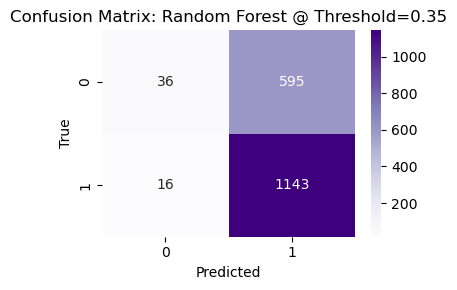

Accuracy: 0.659, Precision: 0.658, Recall: 0.986, F1: 0.789, ROC-AUC: 0.610
Optimal threshold for F1: 0.35
Evaluating: Gradient Boosting


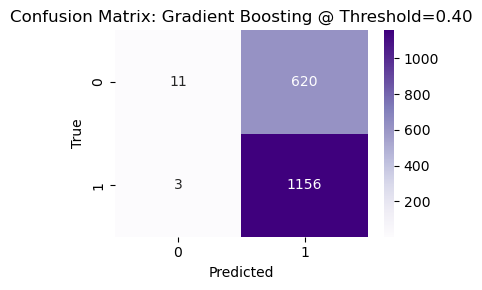

Accuracy: 0.652, Precision: 0.651, Recall: 0.997, F1: 0.788, ROC-AUC: 0.593
Optimal threshold for F1: 0.40
Evaluating: Decision Tree


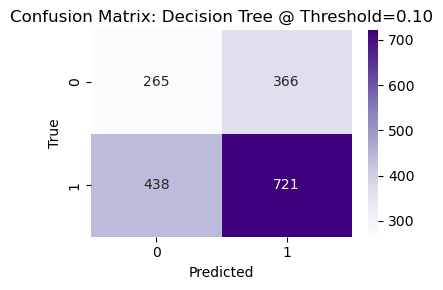

Accuracy: 0.551, Precision: 0.663, Recall: 0.622, F1: 0.642, ROC-AUC: 0.522
Optimal threshold for F1: 0.10
Evaluating: KNN


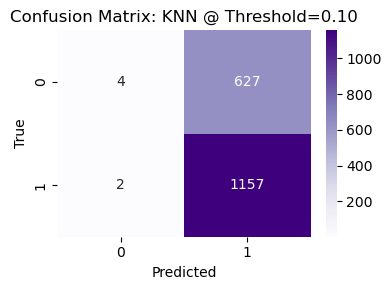

Accuracy: 0.649, Precision: 0.649, Recall: 0.998, F1: 0.786, ROC-AUC: 0.520
Optimal threshold for F1: 0.10
Evaluating: MLP


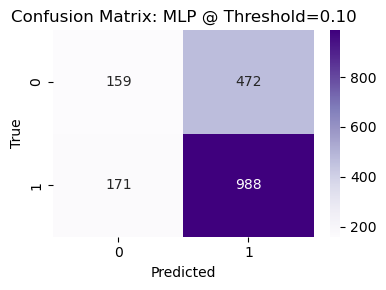

Accuracy: 0.641, Precision: 0.677, Recall: 0.852, F1: 0.754, ROC-AUC: 0.594
Optimal threshold for F1: 0.10
Evaluating: Linear SVC


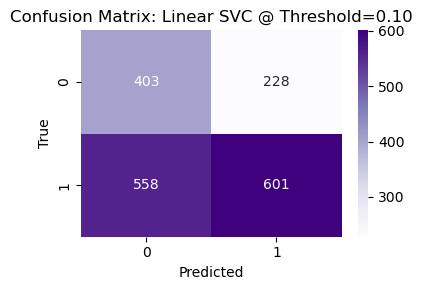

Accuracy: 0.561, Precision: 0.725, Recall: 0.519, F1: 0.605, ROC-AUC: 0.608
Optimal threshold for F1: 0.10
Evaluating: SVC_linear


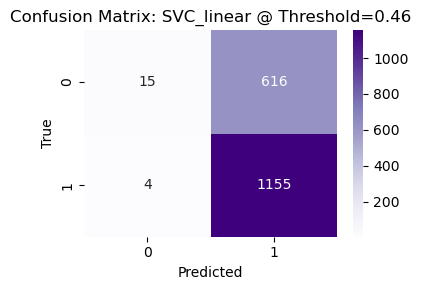

Accuracy: 0.654, Precision: 0.652, Recall: 0.997, F1: 0.788, ROC-AUC: 0.615
Optimal threshold for F1: 0.46
Evaluating: SVC_rbf


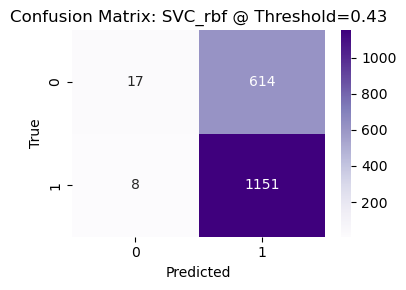

Accuracy: 0.653, Precision: 0.652, Recall: 0.993, F1: 0.787, ROC-AUC: 0.612
Optimal threshold for F1: 0.43
Evaluating: SVC_poly


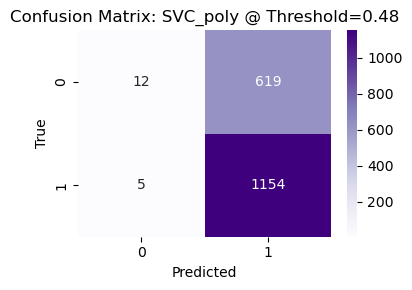

Accuracy: 0.651, Precision: 0.651, Recall: 0.996, F1: 0.787, ROC-AUC: 0.593
Optimal threshold for F1: 0.48
Evaluating: SVC_sigmoid


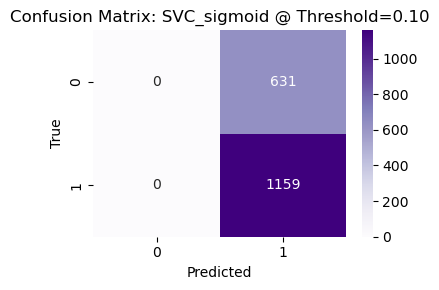

Accuracy: 0.647, Precision: 0.647, Recall: 1.000, F1: 0.786, ROC-AUC: 0.529
Optimal threshold for F1: 0.10
Evaluating: Logistic Regression


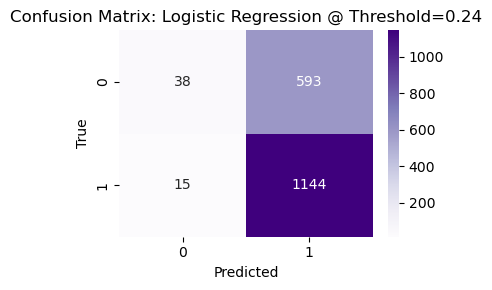

Accuracy: 0.660, Precision: 0.659, Recall: 0.987, F1: 0.790, ROC-AUC: 0.621
Optimal threshold for F1: 0.24
Evaluating: GaussianNB


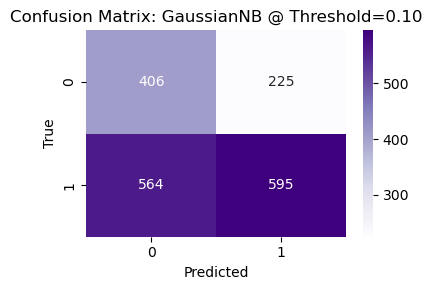

Accuracy: 0.559, Precision: 0.726, Recall: 0.513, F1: 0.601, ROC-AUC: 0.586
Optimal threshold for F1: 0.10
Evaluating: XGBoost


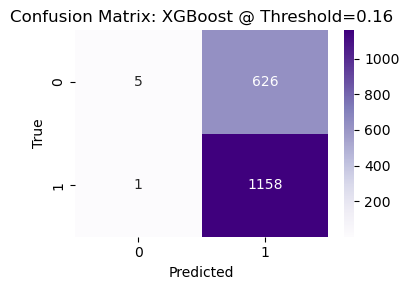

Accuracy: 0.650, Precision: 0.649, Recall: 0.999, F1: 0.787, ROC-AUC: 0.594
Optimal threshold for F1: 0.16


In [9]:
# Results and ROC curves storage
results = {}
roc_curves = {}
optimal_thresholds = {}

for name, model in models.items():
    print(f"Evaluating: {name}")
    try:
        # Fit the model
        if name == 'GaussianNB':
            model.fit(X_train.toarray(), y_train)
            y_score = model.predict_proba(X_test.toarray())[:, 1]
        else:
            model.fit(X_train, y_train)
            y_score = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_test)

        # Threshold sweep to maximize F1
        thresholds = np.linspace(0.1, 0.9, 81)
        f1s = [f1_score(y_test, (y_score >= t).astype(int)) for t in thresholds]
        best_idx = np.argmax(f1s)
        best_threshold = thresholds[best_idx]
        optimal_thresholds[name] = best_threshold
        y_pred = (y_score >= best_threshold).astype(int)

        # Confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(4, 3))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Purples')
        plt.title(f'Confusion Matrix: {name} @ Threshold={best_threshold:.2f}')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.tight_layout()
        plt.show()

        # Metrics
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_score)
        results[name] = {'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1, 'roc_auc': roc_auc}

        print(f"Accuracy: {acc:.3f}, Precision: {prec:.3f}, Recall: {rec:.3f}, F1: {f1:.3f}, ROC-AUC: {roc_auc:.3f}")
        print(f"Optimal threshold for F1: {best_threshold:.2f}")

        # Store ROC curve
        fpr, tpr, _ = roc_curve(y_test, y_score)
        roc_curves[name] = (fpr, tpr, roc_auc)
    except Exception as e:
        print(f"Error evaluating {name}: {e}")

## Metric Comparison Plot

This horizontal bar chart compares each model across five key metrics:  
Accuracy, Precision, Recall, F1-score, and ROC-AUC, all computed using **optimal thresholds** per model.

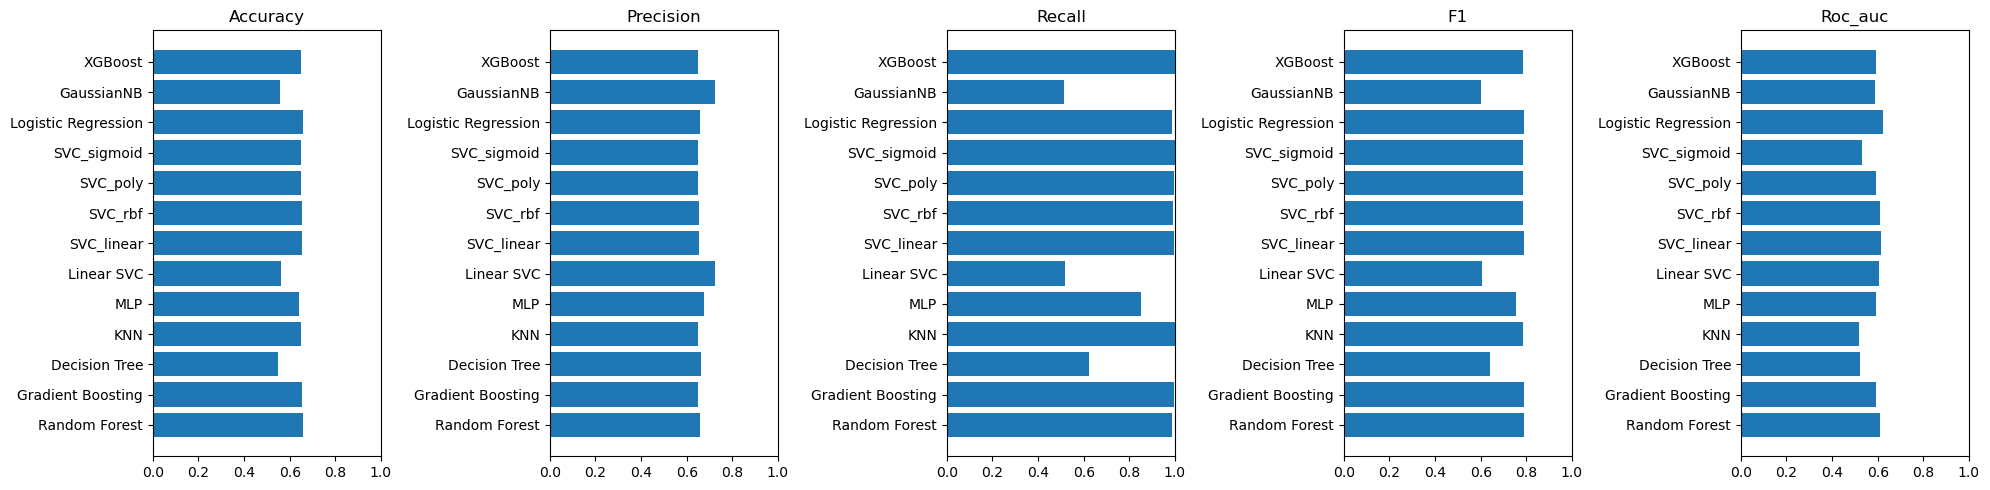

In [10]:
# Compare performance across models
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
fig, axs = plt.subplots(1, len(metrics), figsize=(20, 5))

for i, metric in enumerate(metrics):
    names = list(results.keys())
    values = [results[m][metric] for m in names]
    axs[i].barh(names, values)
    axs[i].set_title(metric.capitalize())
    axs[i].set_xlim(0, 1)

plt.tight_layout()
plt.show()

## ROC Curves Plot

This chart shows how well each model separates the classes.  
Better models have curves closer to the top-left, with higher **AUC** scores indicating stronger separation between positive and negative classes.

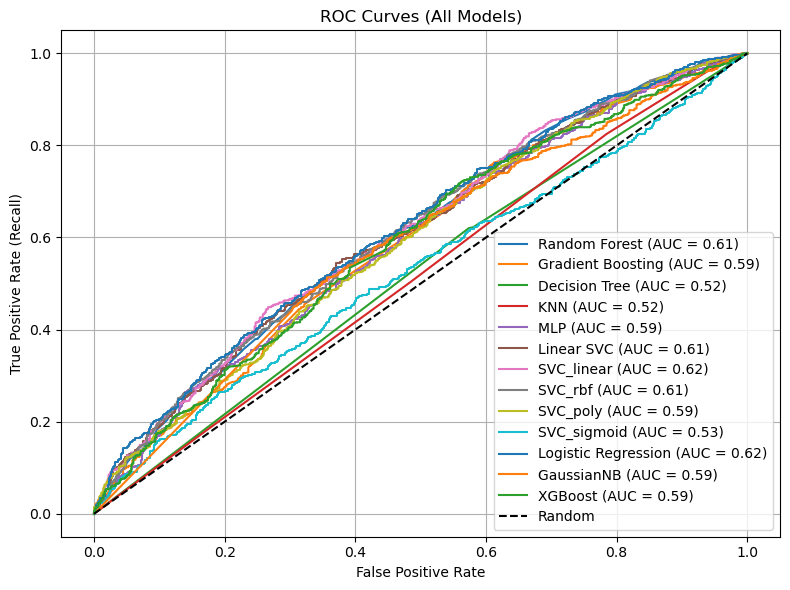

In [14]:
plt.figure(figsize=(8, 6))
for name, (fpr, tpr, auc_val) in roc_curves.items():
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_val:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curves (All Models)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Summary Table

This table shows final performance for all models **at their best thresholds**, sorted by F1-score.  
You can now choose the model that best fits your use case:  
- If minimizing false positives: look for highest **precision**
- If catching more positives: look for highest **recall**
- For balance: highest **F1**

In [17]:
summary_df = pd.DataFrame(results).T.round(3)
summary_df['Best Threshold'] = summary_df.index.map(optimal_thresholds)
summary_df = summary_df[['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'Best Threshold']]
summary_df.sort_values('f1', ascending=False)

,accuracy,precision,recall,f1,roc_auc,Best Threshold
Logistic Regression,0.660,0.659,0.987,0.790,0.621,0.24
Random Forest,0.659,0.658,0.986,0.789,0.610,0.35
Gradient Boosting,0.652,0.651,0.997,0.788,0.593,0.40
SVC_linear,0.654,0.652,0.997,0.788,0.615,0.46
SVC_rbf,0.653,0.652,0.993,0.787,0.612,0.43
SVC_poly,0.651,0.651,0.996,0.787,0.593,0.48
XGBoost,0.650,0.649,0.999,0.787,0.594,0.16
KNN,0.649,0.649,0.998,0.786,0.520,0.10
SVC_sigmoid,0.647,0.647,1.000,0.786,0.529,0.10
MLP,0.641,0.677,0.852,0.754,0.594,0.10
